#### package

In [1]:
import numpy as np                       ### For numerical calculations
from scipy.integrate import solve_ivp    ### Used to solve the system of differential equations
import matplotlib.pyplot as plt          ### Used for plotting the results.

#### Parameters

In [2]:
# Define model parameters
n_patches = 9  # Number of provinces
beta = [0.11607572,0.00972736,0.02554977,0.13890953,0.07344980,0.00473791,0.11356019,0.00020758,0.12895880]  # risk of infection in each province
alpha = [0.0975609756]*n_patches  # Recovery rate (same for all province)
mu = [0.012766666]*n_patches  # Disease-induced death rate (same for all province)



#### Algorithm

In [3]:
# This matirx shows the proportion of individuals from province i who are currently in province j, i.e, Tij/mi for each pair of provinces

P = np.array([
    [0.36413323,0.01194907,0.01147038,0.09455021,0.00512565,0.31076306,0.01438254,0.09283059,0.09479526],
    [0.10511443,0.34974055,0.12114214,0.04460829,0.00319069,0.022089,0.00894944,0.30924382,0.03592163],
    [0.10189617,0.029886,0.34658061,0.45084156,0.01379566,0.01405085,0.00619715,0.01278818,0.02396382],
    [0.37531125,0.01105148,0.01746941,0.36051834,0.00474373,0.02007698,0.01330716,0.01061356,0.1869081],
    [0.0341362,0.04037394,0.37559664,0.15906166,0.34360405,0.00595375,0.00513493,0.00327367,0.03286516],
    [0.4070921,0.00657767,0.00614768,0.01434279,0.00376666,0.35479018,0.02122582,0.01508402,0.17097309],
    [0.02938173,0.0100113,0.00675046,0.01888814,0.00496208,0.31574274,0.36170697,0.02023836,0.2323182],
    [0.46358236,0.03426233,0.00337865,0.00771303,0.00248337,0.07762363,0.03071135,0.34652209,0.03372318],
    [0.09617864,0.02247886,0.02100528,0.14585493,0.01287442,0.20569824,0.06142727,0.02459825,0.40988412]
])


I0 = [0,1,0,16,0,4,2,1,39]  # Initial infected cases of each province
R0 = [0, 0, 0,0, 0, 0,0, 0, 0]  # Initial recovered cases of each province
D0 = [0, 0, 0,0, 0, 0,0, 0, 0]  # Initial disease-induced death cases of each province
S0 = [2781000, 1745999, 1386000,2562984,1152000,2069996,2668998,1386999,6164961]  # initial susceptible cases of each province
N0 = [i + r + s + d for i, r, s, d in zip(I0, R0, S0, D0)]          # Initial total population of each province


# Defining the Multi-Patch SIRD Model
def multi_patch_sird_model(t, y):
    global lambda_
    S = y[:n_patches]                       #### defined the susceptible variable and setup initial susceptible individuals for each province.          
    I = y[n_patches:2*n_patches]            #### defined the infected variable and setup initial infected individuals for each province.
    R = y[2*n_patches:3*n_patches]          #### defined the recovered variable and setup initial recovered individuals for each province. 
    D = y[3*n_patches:4*n_patches]          #### defined the disease-induced death variable and setup initial disease-induced death individuals for each province

    # Infection rate for each province
    numerator = np.sum(P.T * I, axis=1)                                              #### total infected individuals in province j
    denominator = np.sum(P.T * (S + I + R), axis=1)                                  #### total population in province j
    lambda_ = np.sum(beta * P * (numerator / denominator[:, np.newaxis]), axis=1)    #### infection rate in patch i
    

    # Derivatives
    dSdt = -S * lambda_                       #### Susceptible (S) decreases due to infection
    dIdt = S * lambda_ - alpha * I - mu * I   #### Infected (I) changes based on infection, recovery and disease-induced death
    dRdt = alpha * I                          #### Recovered (R) increases as infected recover.
    dDdt = mu * I                             #### Dead (D) increases as infected die.

    return np.concatenate([dSdt, dIdt, dRdt, dDdt])   ### Returns all differential equations as a single array.


# Time span for the simulation from 2020-03-20
#n = 1348                             ### last date of epidemology unit which has data (to 2023-11-27)
#n = 1283                             ### last daya of epidemology unit which has province vice data (to 2023-09-22)
n = 2500                            ### infected distribution closed data  
t_span = (0, n)
t_eval = np.linspace(*t_span, n)



# Initial conditions
y0 = np.array(S0 + I0 + R0 + D0)

# Solves the SIRD model over 1,283 days.
solution = solve_ivp(multi_patch_sird_model, t_span, y0, t_eval=t_eval)
#### The parameter t_eval determines at which time points the solution should be evaluated and returned.
### solve_ivp inbuild function used fourth-order Runge-Kutta method to numerically solves ordinary differential equations (ODEs) over a given time range.


# Extract results
S, I, R, D = np.split(solution.y, 4)   #### extracts S, I, R, D solutions for each province.

#### provinces respectively
provinces = ["Central Province","Eastern Province","North Central Province","North Western Province","Northern Province","Sabaragamuwa Province","Southern Province","Uva Province","Western Province"]


#### Results

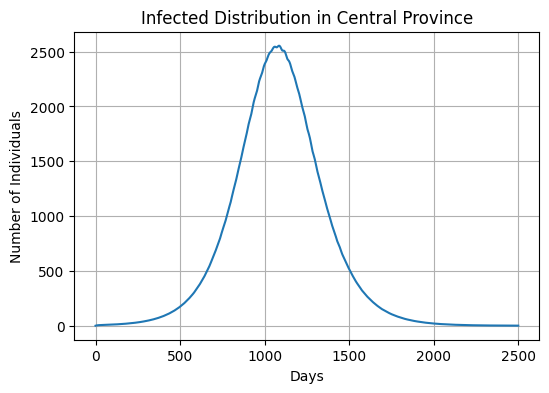

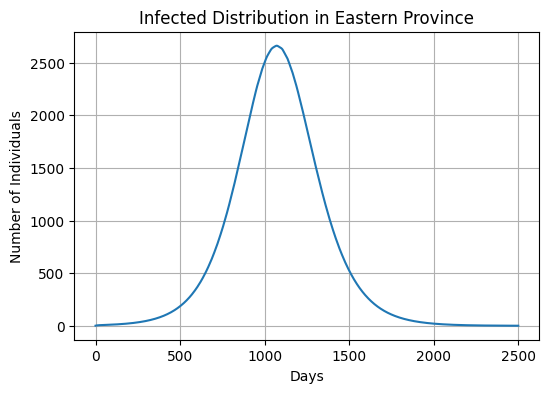

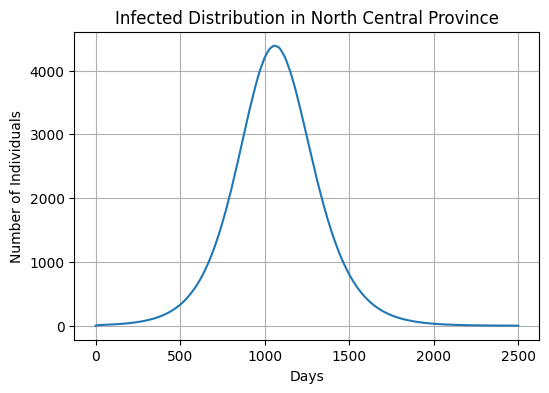

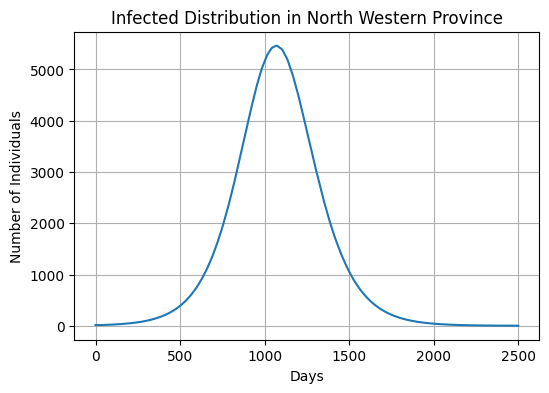

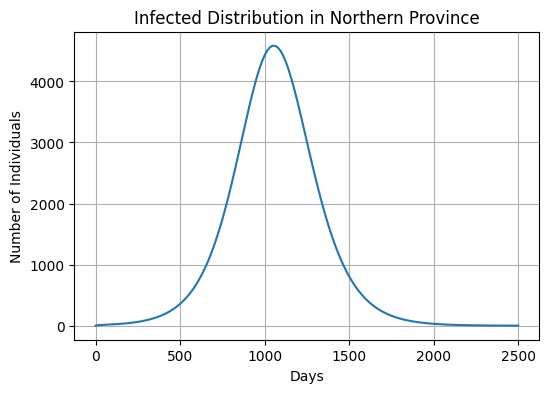

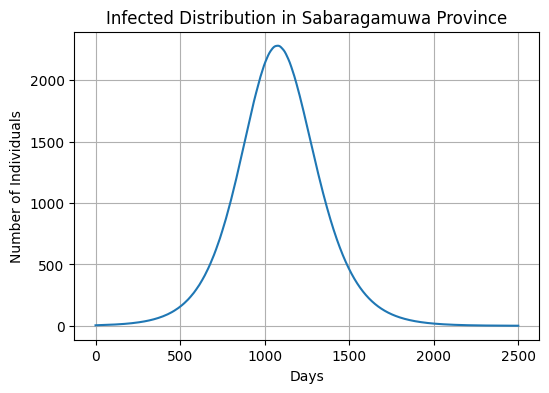

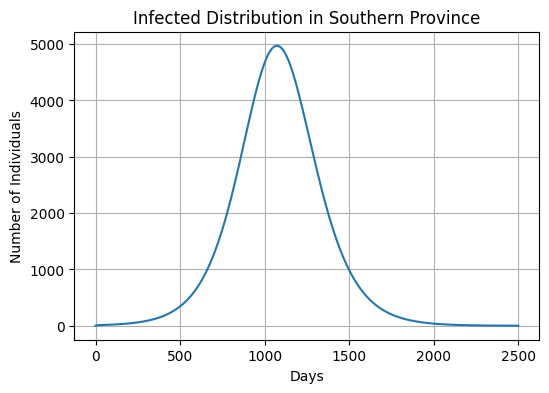

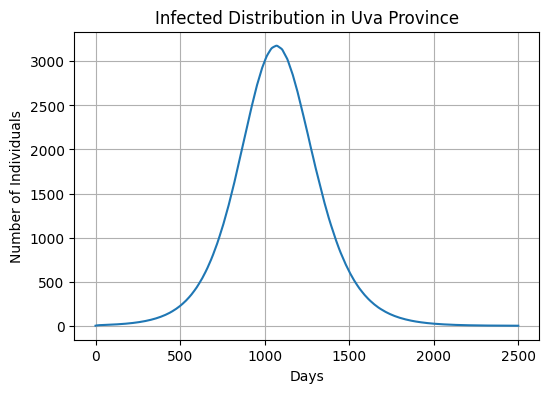

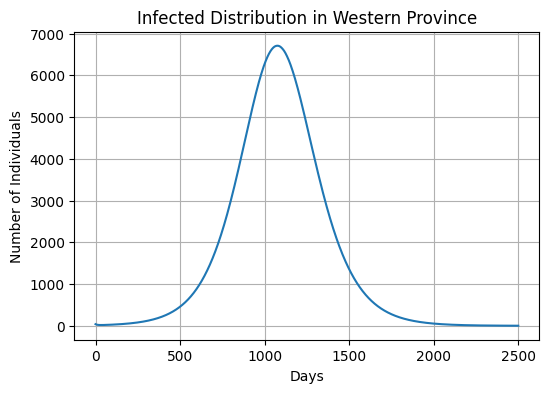

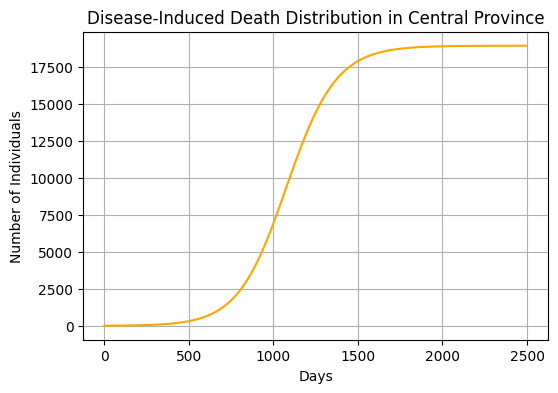

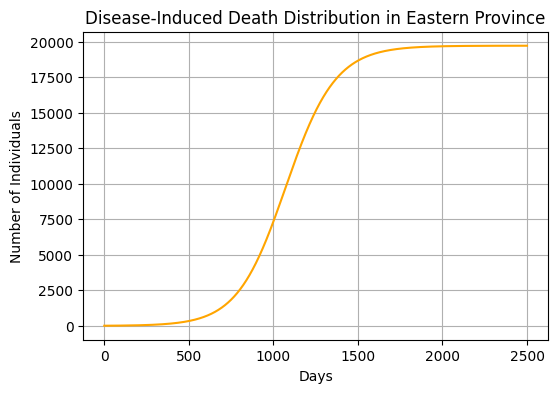

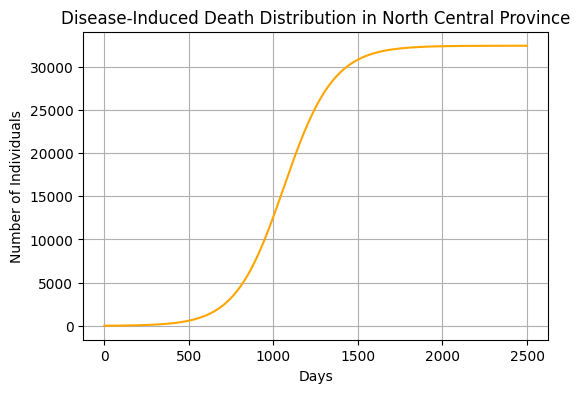

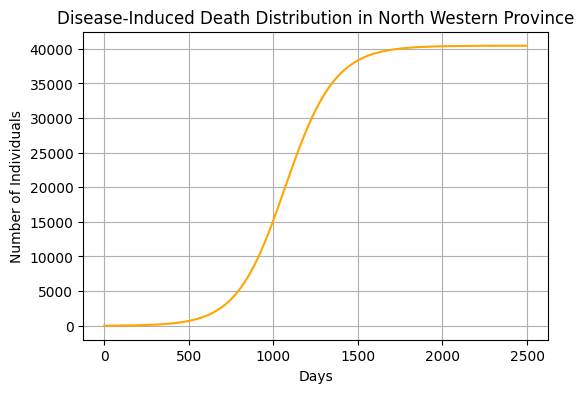

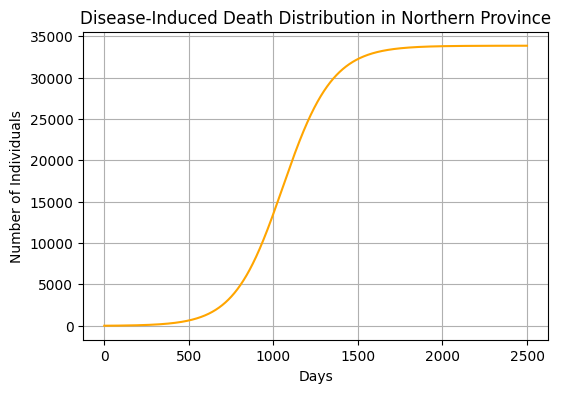

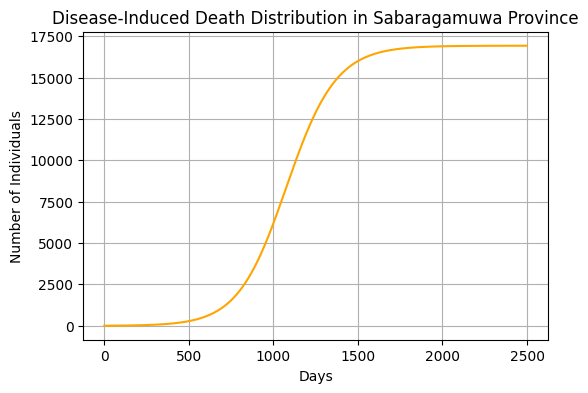

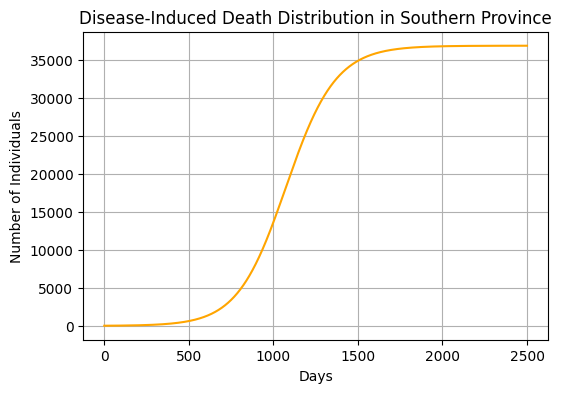

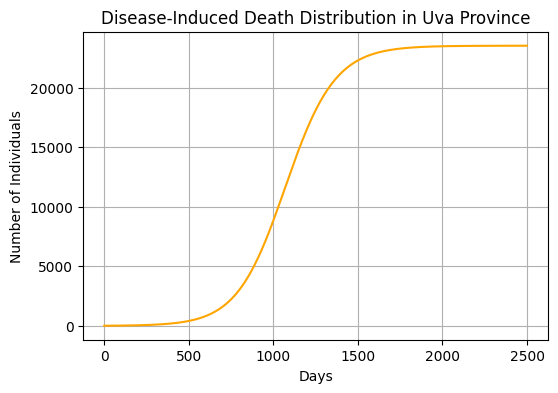

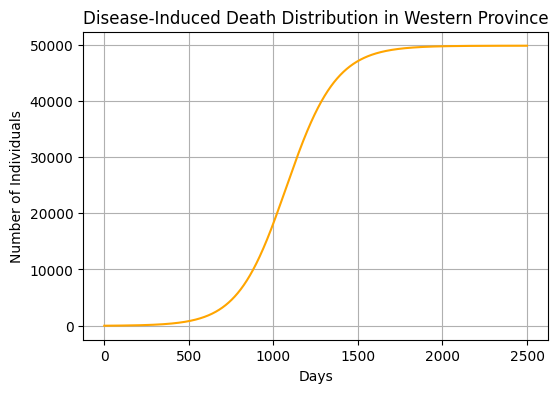

In [4]:
# Plot the results
for i in range(0,n_patches):
    province = provinces[i]
    plt.figure(figsize=(6, 4))
    plt.plot(solution.t, I[i, :])    #### Infected in province i
    plt.xlabel('Days')
    plt.ylabel('Number of Individuals')
    plt.title("Infected Distribution in "+province)
    plt.grid()
    plt.show()


# Plot the results
for i in range(0,n_patches):
    province = provinces[i]
    plt.figure(figsize=(6, 4))
    plt.plot(solution.t, D[i, :],color = 'orange')    #### disease-induced death in province i
    plt.xlabel('Days')
    plt.ylabel('Number of Individuals')
    plt.title("Disease-Induced Death Distribution in "+province)
    plt.grid()
    plt.show()